<h1><center>CS 455/595a: Artificial Neural Network Demonstrations - 2020</center></h1>
<center>Richard S. Stansbury</center>

This notebook applies the ANN techniques for the Titanic Survivors and Boston Housing Prediction models covered in [1] with the [Titanic](https://www.kaggle.com/c/titanic/) and [Boston Housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) data sets.

This demonstration focuses upon showcasing the Keras API to implement an ANN classifier and an ANN regressor for each.

Reference:

[1] Aurelen Geron. *Hands on Machine Learning with Scikit-Learn & TensorFlow* O'Reilley Media Inc, 2017.

[2] Aurelen Geron. "ageron/handson-ml: A series of Jupyter notebooks that walk you through the fundamentals of Machine Learning and Deep Learning in python using Scikit-Learn and TensorFlow." Github.com, online at: https://github.com/ageron/handson-ml [last accessed 2019-03-01]

[2] Aurelen Geron. *Hands on Machine Learning with Scikit-Learn, Keras, & TensorFlow* 2nd Edition, O'Reilley Media Inc, 2019.

[3] Aurelen Geron. "ageron/handson-ml: A series of Jupyter notebooks that walk you through the fundamentals of Machine Learning and Deep Learning in python using Scikit-Learn and TensorFlow." Github.com, online at: https://github.com/ageron/handson-ml2 [last accessed 2020-04-01]

**Table of Contents**
1. [Titanic Survivor ANN Classifiers](#Titanic-Survivor-Classifier)
 
2. [Boston Housing Cost Ensemble ANN Regressor](#Boston-Housing-Cost-Estimator)

## Library and Data Setup

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline 
import numpy as np
import pandas as pd
import os

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
assert keras.__version__ >= "2.0"


#From Ageron demo if running under Collaboratory this will remind you to turn on your GPU.
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


No GPU was detected. CNNs can be very slow without a GPU.


Import the data and apply pipelines to pre-process the data.

In [3]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split

# Read data from input files into Pandas data frames
data_path = os.path.join("datasets","titanic")
train_filename = "train.csv"
test_filename = "test.csv"

def read_csv(data_path, filename):
    joined_path = os.path.join(data_path, filename)
    return pd.read_csv(joined_path)

# Read CSV file into Pandas Dataframes
train_df = read_csv(data_path, train_filename)

# Defining Data Pre-Processing Pipelines
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes):
        self.attributes = attributes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes]

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X], 
                                       index = X.columns)
        return self
    
    def transform(self, X):
        return X.fillna(self.most_frequent)


numeric_pipe = Pipeline([
        ("Select", DataFrameSelector(["Age", "Fare", "SibSp", "Parch"])), # Selects Fields from dataframe
        ("Imputer", SimpleImputer(strategy="median")),   # Fills in NaN w/ median value for its column
        ("Scaler", StandardScaler()),
    ])

categories_pipe = Pipeline([
        ("Select", DataFrameSelector(["Pclass", "Sex"])), # Selects Fields from dataframe
        ("MostFreqImp", MostFrequentImputer()), # Fill in NaN with most frequent
        ("OneHot", OneHotEncoder(sparse=False, categories='auto')), # Onehot encode
    ])

preprocessing_pipe = FeatureUnion(transformer_list = [
        ("numeric pipeline", numeric_pipe), 
        ("categories pipeline", categories_pipe)
     ]) 

# Process Input Data Using Pipleines
X_data = preprocessing_pipe.fit_transform(train_df)
y_data = train_df["Survived"].values.reshape(-1,1)

# Process the output data.
feature_names = ["Age", "Fare", "SibSp", "Parch", "Class0", "class1","Sex0", "Sex1"]

print(X_data.shape)
print(y_data.shape)

(891, 9)
(891, 1)


Split the data into a training and validation set.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


(477, 9)
(179, 9)
(235, 9)
(477, 1)
(179, 1)
(235, 1)


## Model Set Up

In [5]:
model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.Dense(50, activation='relu'),        
    keras.layers.Dense(1, activation='sigmoid')
])

In [5]:
model.layers

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                500       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


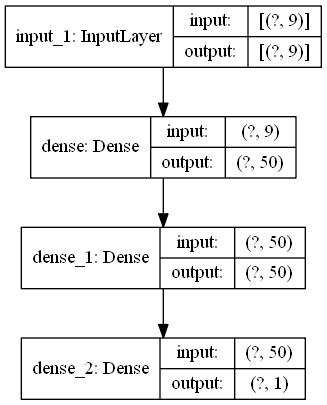

In [7]:
from sklearn.tree import export_graphviz
from IPython.display import Image as PImage
import pydot

keras.utils.plot_model(model, "Titanic survivor classifier.png", show_shapes=True)

## Model Training

In [6]:
keras.backend.clear_session()

lr = 0.1
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.SGD(learning_rate=lr),
              metrics=['accuracy', 'mse'])

Train on 477 samples, validate on 235 samples
Epoch 1/20
477/477 [==============================] - 1s 2ms/sample - loss: 0.6564 - accuracy: 0.6352 - mse: 0.2307 - val_loss: 0.6016 - val_accuracy: 0.6809 - val_mse: 0.2060
Epoch 2/20
477/477 [==============================] - 0s 102us/sample - loss: 0.5674 - accuracy: 0.7086 - mse: 0.1905 - val_loss: 0.5442 - val_accuracy: 0.7702 - val_mse: 0.1799
Epoch 3/20
477/477 [==============================] - 0s 107us/sample - loss: 0.5241 - accuracy: 0.7526 - mse: 0.1717 - val_loss: 0.5135 - val_accuracy: 0.7872 - val_mse: 0.1667
Epoch 4/20
477/477 [==============================] - 0s 105us/sample - loss: 0.4964 - accuracy: 0.7757 - mse: 0.1602 - val_loss: 0.4929 - val_accuracy: 0.8000 - val_mse: 0.1583
Epoch 5/20
477/477 [==============================] - 0s 109us/sample - loss: 0.4767 - accuracy: 0.7862 - mse: 0.1524 - val_loss: 0.4788 - val_accuracy: 0.8085 - val_mse: 0.1528
Epoch 6/20
477/477 [==============================] - 0s 107us/sam

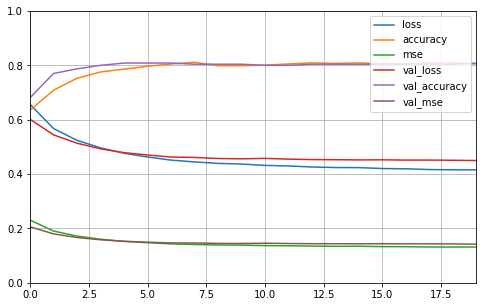

In [7]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val,y_val))


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Model Validation

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, precision_recall_curve



def plot_precision_recall_curve(y, y_score):
    """
    Prints a precision vs. recall curve.
    """
    precisions, recalls, thresholds = precision_recall_curve(y, y_score)
    plt.figure(figsize=(8, 6))
    plt.title("Precision-Recall Curve")
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.show()
    

def plot_roc(y, y_score):
    """
    Prints a Receiver Operating Characteristic (ROC) Curve
    """
    fpr, tpr, thresholds = roc_curve(y, y_score)
    plt.figure(figsize=(8, 6))
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.show()
    
def evaluate_classifier(y, y_pred):
    """
    Prints the confusion matrix, precision score, recall score, and f1 score
    """
  
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("Pecision Score = " + str(precision_score(y, y_pred)))
    print("Recall Score = " + str(recall_score(y,y_pred)))
    print("F1 Score = " + str(f1_score(y,y_pred)))

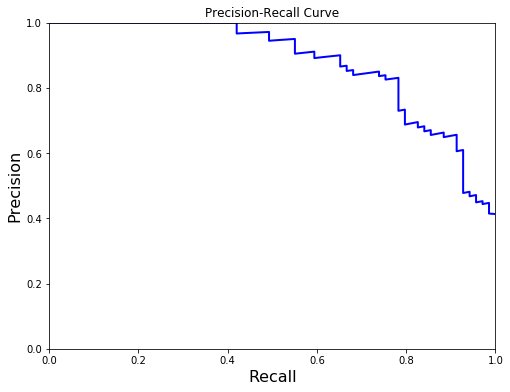

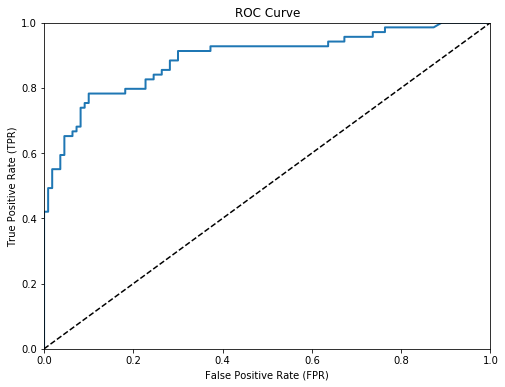

Confusion Matrix:
[[94 16]
 [15 54]]
Pecision Score = 0.7714285714285715
Recall Score = 0.782608695652174
F1 Score = 0.7769784172661871


In [10]:

y_pred_prob = model.predict(X_test)
plot_precision_recall_curve(y_test, y_pred_prob)
plot_roc(y_test, y_pred_prob)


y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]
evaluate_classifier(y_test, y_pred)


# Boston Housing Cost Estimator

Building off the classifier examples above, this section demonstrates an implementation of a simple ANN regressor for boston housing.

## Library and Data Setup

In [12]:
# Load Data Set
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
boston_housing_data = datasets.load_boston()

scaler = MinMaxScaler()
bouston_housing_data_instances = scaler.fit_transform(boston_housing_data.data)
bouston_housing_data_instances.shape


X_train, X_test, y_train, y_test = train_test_split(bouston_housing_data_instances,
                                                   boston_housing_data.target,
                                                   test_size=0.20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(270, 13)
(102, 13)
(134, 13)
(270,)
(102,)
(134,)


## Model Configuration and Training

Train on 270 samples, validate on 134 samples
Epoch 1/100
270/270 [==============================] - 1s 2ms/sample - loss: 551.2513 - mae: 21.7739 - val_loss: 517.9951 - val_mae: 21.0726
Epoch 2/100
270/270 [==============================] - 0s 107us/sample - loss: 390.3072 - mae: 17.6357 - val_loss: 159.4104 - val_mae: 10.0055
Epoch 3/100
270/270 [==============================] - 0s 122us/sample - loss: 102.2147 - mae: 7.5220 - val_loss: 83.8466 - val_mae: 6.9997
Epoch 4/100
270/270 [==============================] - 0s 115us/sample - loss: 83.0619 - mae: 6.7098 - val_loss: 70.9035 - val_mae: 6.3450
Epoch 5/100
270/270 [==============================] - 0s 103us/sample - loss: 70.6672 - mae: 6.1594 - val_loss: 62.1209 - val_mae: 5.7020
Epoch 6/100
270/270 [==============================] - 0s 118us/sample - loss: 62.2358 - mae: 5.5921 - val_loss: 52.5895 - val_mae: 5.1302
Epoch 7/100
270/270 [==============================] - 0s 126us/sample - loss: 54.5255 - mae: 5.1906 - val_loss: 

270/270 [==============================] - 0s 118us/sample - loss: 20.0382 - mae: 3.0814 - val_loss: 10.5381 - val_mae: 2.2909
Epoch 60/100
270/270 [==============================] - 0s 122us/sample - loss: 19.0667 - mae: 2.9910 - val_loss: 9.1268 - val_mae: 2.2462
Epoch 61/100
270/270 [==============================] - 0s 115us/sample - loss: 17.8680 - mae: 2.8683 - val_loss: 8.9911 - val_mae: 2.1767
Epoch 62/100
270/270 [==============================] - 0s 111us/sample - loss: 18.7304 - mae: 2.9313 - val_loss: 9.7260 - val_mae: 2.4513
Epoch 63/100
270/270 [==============================] - 0s 111us/sample - loss: 18.2896 - mae: 2.9873 - val_loss: 9.1513 - val_mae: 2.3065
Epoch 64/100
270/270 [==============================] - 0s 111us/sample - loss: 17.1183 - mae: 2.8329 - val_loss: 10.2378 - val_mae: 2.2600
Epoch 65/100
270/270 [==============================] - 0s 111us/sample - loss: 17.8533 - mae: 2.8332 - val_loss: 12.3584 - val_mae: 2.9081
Epoch 66/100
270/270 [===============

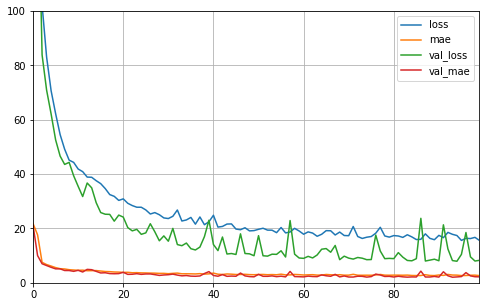

In [14]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.Dense(97, activation='relu'),             
    keras.layers.Dense(97, activation='relu'),            
    keras.layers.Dense(97, activation='relu'),  
    keras.layers.Dense(1)
])

lr = 0.00059
model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.SGD(learning_rate=lr),
              metrics=['mae'])

history = model.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data = (X_val, y_val),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 100)
plt.show()

## Demonstration of Hyperparameter Tuning using RandomSearch from SKLearn

In [185]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

keras.backend.clear_session()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=13):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


param_dist = {
    'n_hidden': [0,1,2,3],
    'n_neurons': np.arange(1,100),
    'learning_rate': reciprocal(3e-4,3e-2),
}


model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

rnd_search = RandomizedSearchCV(model, 
                                param_dist, 
                                n_iter=10, 
                                cv=3, verbose=2, 
                                error_score='raise-deprecating')
print(X_train)

rnd_search.fit(X_train, 
               y_train, 
               epochs=100,
               validation_data=(X_val, y_val),
               callbacks=[keras.callbacks.EarlyStopping(patience=10)])


rnd_search.best_params_



[[1.42423481e-02 0.00000000e+00 7.00879765e-01 ... 2.23404255e-01
  8.53799990e-01 1.04028698e-01]
 [2.42284243e-03 2.00000000e-01 2.38269795e-01 ... 6.38297872e-01
  9.84542841e-01 1.33830022e-01]
 [3.00551153e-04 0.00000000e+00 1.73387097e-01 ... 8.08510638e-01
  9.98083615e-01 1.87086093e-01]
 ...
 [9.58976229e-04 0.00000000e+00 3.79398827e-01 ... 7.02127660e-01
  9.84895860e-01 1.04580574e-01]
 [2.74290580e-02 0.00000000e+00 7.00879765e-01 ... 2.23404255e-01
  2.22678905e-01 3.97626932e-01]
 [8.50512555e-04 0.00000000e+00 4.93401760e-01 ... 3.61702128e-01
  1.00000000e+00 2.39238411e-01]]
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.012719852237765745, n_hidden=3, n_neurons=41 ....
Train on 180 samples, validate on 134 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


180/180 [==============================] - 0s 3ms/sample - loss: 1196.1835 - val_loss: 489.9852
Epoch 2/100
180/180 [==============================] - 0s 133us/sample - loss: inf - val_loss: nan
Epoch 3/100
180/180 [==============================] - 0s 111us/sample - loss: nan - val_loss: nan
Epoch 4/100
180/180 [==============================] - 0s 105us/sample - loss: nan - val_loss: nan
Epoch 5/100
180/180 [==============================] - 0s 139us/sample - loss: nan - val_loss: nan
Epoch 6/100
180/180 [==============================] - 0s 122us/sample - loss: nan - val_loss: nan
Epoch 7/100
180/180 [==============================] - 0s 138us/sample - loss: nan - val_loss: nan
Epoch 8/100
180/180 [==============================] - 0s 150us/sample - loss: nan - val_loss: nan
Epoch 9/100
180/180 [==============================] - 0s 139us/sample - loss: nan - val_loss: nan
Epoch 10/100


C:\Users\richard.stansbury\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1261: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


180/180 [==============================] - 0s 144us/sample - loss: nan - val_loss: nan
Epoch 11/100
90/90 [==============================] - 0s 78us/sample - loss: nan
[CV]  learning_rate=0.012719852237765745, n_hidden=3, n_neurons=41, total=   0.9s
[CV] learning_rate=0.012719852237765745, n_hidden=3, n_neurons=41 ....
Train on 180 samples, validate on 134 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


180/180 [==============================] - 0s 3ms/sample - loss: 4071.7594 - val_loss: 593.7357
Epoch 2/100
180/180 [==============================] - 0s 111us/sample - loss: 487.3055 - val_loss: 490.7452
Epoch 3/100
180/180 [==============================] - 0s 116us/sample - loss: 394.8050 - val_loss: 83.0642
Epoch 4/100
180/180 [==============================] - 0s 122us/sample - loss: 89.6556 - val_loss: 97.9206
Epoch 5/100
180/180 [==============================] - 0s 111us/sample - loss: 85.1595 - val_loss: 441.2018
Epoch 6/100
180/180 [==============================] - 0s 150us/sample - loss: 283.8864 - val_loss: 78.8014
Epoch 7/100
180/180 [==============================] - 0s 139us/sample - loss: 87.7674 - val_loss: 94.3075
Epoch 8/100
180/180 [==============================] - 0s 127us/sample - loss: 98.9689 - val_loss: 74.8846
Epoch 9/100
180/180 [==============================] - 0s 122us/sample - loss: 86.0846 - val_loss: 76.4636
Epoch 10/100
180/180 [=====================

Epoch 30/100
180/180 [==============================] - 0s 116us/sample - loss: 43.4297 - val_loss: 44.5995
Epoch 31/100
180/180 [==============================] - 0s 94us/sample - loss: 42.9528 - val_loss: 45.3071
Epoch 32/100
180/180 [==============================] - 0s 117us/sample - loss: 42.2126 - val_loss: 44.5272
Epoch 33/100
180/180 [==============================] - 0s 83us/sample - loss: 41.7152 - val_loss: 43.8896
Epoch 34/100
180/180 [==============================] - 0s 122us/sample - loss: 41.0549 - val_loss: 43.6886
Epoch 35/100
180/180 [==============================] - 0s 111us/sample - loss: 40.6928 - val_loss: 42.4251
Epoch 36/100
180/180 [==============================] - 0s 89us/sample - loss: 39.7930 - val_loss: 44.8592
Epoch 37/100
180/180 [==============================] - 0s 128us/sample - loss: 39.6122 - val_loss: 42.5034
Epoch 38/100
180/180 [==============================] - 0s 94us/sample - loss: 38.7819 - val_loss: 42.0296
Epoch 39/100
180/180 [==========

Epoch 79/100
180/180 [==============================] - 0s 127us/sample - loss: 24.1087 - val_loss: 21.6599
Epoch 80/100
180/180 [==============================] - 0s 105us/sample - loss: 23.9778 - val_loss: 21.5151
Epoch 81/100
180/180 [==============================] - 0s 122us/sample - loss: 24.3527 - val_loss: 21.3341
Epoch 82/100
180/180 [==============================] - 0s 139us/sample - loss: 23.6168 - val_loss: 21.2123
Epoch 83/100
180/180 [==============================] - 0s 100us/sample - loss: 23.4092 - val_loss: 21.5334
Epoch 84/100
180/180 [==============================] - 0s 111us/sample - loss: 23.3348 - val_loss: 21.1635
Epoch 85/100
180/180 [==============================] - 0s 138us/sample - loss: 23.2385 - val_loss: 21.0390
Epoch 86/100
180/180 [==============================] - 0s 116us/sample - loss: 23.5192 - val_loss: 21.2083
Epoch 87/100
180/180 [==============================] - 0s 111us/sample - loss: 22.7264 - val_loss: 20.7094
Epoch 88/100
180/180 [======

Epoch 9/100
180/180 [==============================] - 0s 139us/sample - loss: 90.4947 - val_loss: 79.2227
Epoch 10/100
180/180 [==============================] - 0s 144us/sample - loss: 91.3755 - val_loss: 139.3293
Epoch 11/100
180/180 [==============================] - 0s 144us/sample - loss: 128.0515 - val_loss: 278.6838
Epoch 12/100
180/180 [==============================] - 0s 144us/sample - loss: 177.3534 - val_loss: 79.3570
Epoch 13/100
180/180 [==============================] - 0s 144us/sample - loss: 104.2123 - val_loss: 80.0164
Epoch 14/100
180/180 [==============================] - 0s 122us/sample - loss: 91.1814 - val_loss: 141.2271
Epoch 15/100
180/180 [==============================] - 0s 144us/sample - loss: 115.6222 - val_loss: 83.7780
Epoch 16/100
180/180 [==============================] - 0s 144us/sample - loss: 90.9751 - val_loss: 82.2361
Epoch 17/100
180/180 [==============================] - 0s 139us/sample - loss: 85.9124 - val_loss: 83.9539
Epoch 18/100
180/180 [

180/180 [==============================] - 0s 127us/sample - loss: 141.7907 - val_loss: 123.5227
Epoch 8/100
180/180 [==============================] - 0s 117us/sample - loss: 130.1258 - val_loss: 114.6833
Epoch 9/100
180/180 [==============================] - 0s 122us/sample - loss: 122.1616 - val_loss: 108.3150
Epoch 10/100
180/180 [==============================] - 0s 128us/sample - loss: 116.1314 - val_loss: 103.5973
Epoch 11/100
180/180 [==============================] - 0s 111us/sample - loss: 111.5833 - val_loss: 99.9667
Epoch 12/100
180/180 [==============================] - 0s 111us/sample - loss: 108.1346 - val_loss: 96.9019
Epoch 13/100
180/180 [==============================] - 0s 133us/sample - loss: 105.1211 - val_loss: 94.2317
Epoch 14/100
180/180 [==============================] - 0s 111us/sample - loss: 102.3965 - val_loss: 92.0104
Epoch 15/100
180/180 [==============================] - 0s 111us/sample - loss: 100.2853 - val_loss: 89.9146
Epoch 16/100
180/180 [========

Epoch 83/100
180/180 [==============================] - 0s 94us/sample - loss: 51.8723 - val_loss: 46.4510
Epoch 84/100
180/180 [==============================] - 0s 122us/sample - loss: 51.6482 - val_loss: 46.2719
Epoch 85/100
180/180 [==============================] - 0s 111us/sample - loss: 51.5660 - val_loss: 46.0483
Epoch 86/100
180/180 [==============================] - 0s 94us/sample - loss: 51.2983 - val_loss: 45.8767
Epoch 87/100
180/180 [==============================] - 0s 117us/sample - loss: 51.0613 - val_loss: 45.7235
Epoch 88/100
180/180 [==============================] - 0s 100us/sample - loss: 50.8892 - val_loss: 45.5241
Epoch 89/100
180/180 [==============================] - 0s 122us/sample - loss: 50.6711 - val_loss: 45.3926
Epoch 90/100
180/180 [==============================] - 0s 105us/sample - loss: 50.4710 - val_loss: 45.3194
Epoch 91/100
180/180 [==============================] - 0s 94us/sample - loss: 50.3085 - val_loss: 45.1962
Epoch 92/100
180/180 [=========

180/180 [==============================] - 0s 161us/sample - loss: 40.2021 - val_loss: 39.7264
Epoch 30/100
180/180 [==============================] - 0s 166us/sample - loss: 39.2853 - val_loss: 39.5705
Epoch 31/100
180/180 [==============================] - 0s 161us/sample - loss: 37.9969 - val_loss: 39.1921
Epoch 32/100
180/180 [==============================] - 0s 161us/sample - loss: 37.4670 - val_loss: 38.8147
Epoch 33/100
180/180 [==============================] - 0s 161us/sample - loss: 37.0423 - val_loss: 38.8581
Epoch 34/100
180/180 [==============================] - 0s 161us/sample - loss: 35.7608 - val_loss: 37.6312
Epoch 35/100
180/180 [==============================] - 0s 155us/sample - loss: 35.2284 - val_loss: 38.6807
Epoch 36/100
180/180 [==============================] - 0s 150us/sample - loss: 34.7451 - val_loss: 37.1923
Epoch 37/100
180/180 [==============================] - 0s 150us/sample - loss: 33.8927 - val_loss: 36.8175
Epoch 38/100
180/180 [===================

Epoch 78/100
180/180 [==============================] - 0s 139us/sample - loss: 20.8723 - val_loss: 18.7402
Epoch 79/100
180/180 [==============================] - 0s 127us/sample - loss: 21.2806 - val_loss: 18.5253
Epoch 80/100
180/180 [==============================] - 0s 144us/sample - loss: 20.3637 - val_loss: 18.8502
Epoch 81/100
180/180 [==============================] - 0s 144us/sample - loss: 20.9587 - val_loss: 18.3616
Epoch 82/100
180/180 [==============================] - 0s 150us/sample - loss: 20.4930 - val_loss: 18.6234
Epoch 83/100
180/180 [==============================] - 0s 133us/sample - loss: 20.4069 - val_loss: 19.0064
Epoch 84/100
180/180 [==============================] - 0s 133us/sample - loss: 20.5167 - val_loss: 17.9761
Epoch 85/100
180/180 [==============================] - 0s 150us/sample - loss: 19.9304 - val_loss: 17.8402
Epoch 86/100
180/180 [==============================] - 0s 150us/sample - loss: 20.3702 - val_loss: 18.1544
Epoch 87/100
180/180 [======

180/180 [==============================] - 0s 116us/sample - loss: 30.3901 - val_loss: 88.2973
Epoch 25/100
180/180 [==============================] - 0s 105us/sample - loss: 45.4769 - val_loss: 21.7680
Epoch 26/100
180/180 [==============================] - 0s 122us/sample - loss: 18.3134 - val_loss: 19.4928
Epoch 27/100
180/180 [==============================] - 0s 105us/sample - loss: 27.0234 - val_loss: 45.1553
Epoch 28/100
180/180 [==============================] - 0s 111us/sample - loss: 47.7848 - val_loss: 30.3373
Epoch 29/100
180/180 [==============================] - 0s 116us/sample - loss: 21.4112 - val_loss: 23.5503
Epoch 30/100
180/180 [==============================] - 0s 94us/sample - loss: 16.3015 - val_loss: 24.3554
Epoch 31/100
180/180 [==============================] - 0s 117us/sample - loss: 19.9543 - val_loss: 38.4057
Epoch 32/100
180/180 [==============================] - 0s 116us/sample - loss: 48.7563 - val_loss: 18.1166
Epoch 33/100
180/180 [====================

180/180 [==============================] - 0s 116us/sample - loss: 20.9548 - val_loss: 14.9118
Epoch 35/100
180/180 [==============================] - 0s 105us/sample - loss: 33.0493 - val_loss: 46.5557
Epoch 36/100
180/180 [==============================] - 0s 122us/sample - loss: 29.5350 - val_loss: 14.4745
Epoch 37/100
180/180 [==============================] - 0s 127us/sample - loss: 36.5460 - val_loss: 16.2668
Epoch 38/100
180/180 [==============================] - 0s 105us/sample - loss: 19.6752 - val_loss: 20.1559
Epoch 39/100
180/180 [==============================] - 0s 122us/sample - loss: 25.3779 - val_loss: 14.6114
Epoch 40/100
180/180 [==============================] - 0s 116us/sample - loss: 20.8150 - val_loss: 56.6781
Epoch 41/100
180/180 [==============================] - 0s 111us/sample - loss: 37.8866 - val_loss: 45.5416
Epoch 42/100
180/180 [==============================] - 0s 122us/sample - loss: 30.5656 - val_loss: 65.9133
Epoch 43/100
180/180 [===================

Epoch 51/100
90/90 [==============================] - 0s 67us/sample - loss: 92.3742
[CV]  learning_rate=0.024044126525986375, n_hidden=2, n_neurons=11, total=   1.7s
[CV] learning_rate=0.024044126525986375, n_hidden=2, n_neurons=11 ....
Train on 180 samples, validate on 134 samples
Epoch 1/100
180/180 [==============================] - 1s 3ms/sample - loss: 424.1770 - val_loss: 1424.9258
Epoch 2/100
180/180 [==============================] - 0s 111us/sample - loss: 565.7866 - val_loss: 129.1448
Epoch 3/100
180/180 [==============================] - 0s 105us/sample - loss: 103.8966 - val_loss: 71.6629
Epoch 4/100
180/180 [==============================] - 0s 105us/sample - loss: 100.0820 - val_loss: 86.8151
Epoch 5/100
180/180 [==============================] - 0s 100us/sample - loss: 87.9412 - val_loss: 86.9664
Epoch 6/100
180/180 [==============================] - 0s 105us/sample - loss: 95.6688 - val_loss: 100.6473
Epoch 7/100
180/180 [==============================] - 0s 116us/samp

180/180 [==============================] - 0s 127us/sample - loss: 299.4022 - val_loss: 219.5985
Epoch 6/100
180/180 [==============================] - 0s 122us/sample - loss: 203.0182 - val_loss: 147.2800
Epoch 7/100
180/180 [==============================] - 0s 105us/sample - loss: 143.9796 - val_loss: 113.2914
Epoch 8/100
180/180 [==============================] - 0s 133us/sample - loss: 118.2880 - val_loss: 100.3576
Epoch 9/100
180/180 [==============================] - 0s 111us/sample - loss: 107.9825 - val_loss: 94.4724
Epoch 10/100
180/180 [==============================] - 0s 105us/sample - loss: 102.7802 - val_loss: 90.4203
Epoch 11/100
180/180 [==============================] - 0s 127us/sample - loss: 98.6381 - val_loss: 87.0540
Epoch 12/100
180/180 [==============================] - 0s 111us/sample - loss: 95.1821 - val_loss: 83.8089
Epoch 13/100
180/180 [==============================] - 0s 116us/sample - loss: 91.9516 - val_loss: 80.7091
Epoch 14/100
180/180 [=============

Epoch 81/100
180/180 [==============================] - 0s 94us/sample - loss: 36.5255 - val_loss: 33.2145
Epoch 82/100
180/180 [==============================] - 0s 105us/sample - loss: 36.3618 - val_loss: 32.6618
Epoch 83/100
180/180 [==============================] - 0s 122us/sample - loss: 36.1229 - val_loss: 32.6888
Epoch 84/100
180/180 [==============================] - 0s 94us/sample - loss: 36.0483 - val_loss: 32.6651
Epoch 85/100
180/180 [==============================] - 0s 116us/sample - loss: 35.5724 - val_loss: 31.8900
Epoch 86/100
180/180 [==============================] - 0s 116us/sample - loss: 35.3182 - val_loss: 31.6267
Epoch 87/100
180/180 [==============================] - 0s 89us/sample - loss: 35.3379 - val_loss: 31.7616
Epoch 88/100
180/180 [==============================] - 0s 122us/sample - loss: 34.8867 - val_loss: 31.5495
Epoch 89/100
180/180 [==============================] - 0s 94us/sample - loss: 34.7502 - val_loss: 31.4409
Epoch 90/100
180/180 [==========

180/180 [==============================] - 0s 111us/sample - loss: 23.7420 - val_loss: 20.3766
Epoch 28/100
180/180 [==============================] - 0s 94us/sample - loss: 15.0562 - val_loss: 17.8905
Epoch 29/100
180/180 [==============================] - 0s 122us/sample - loss: 18.0561 - val_loss: 17.0210
Epoch 30/100
180/180 [==============================] - 0s 94us/sample - loss: 19.3781 - val_loss: 22.2817
Epoch 31/100
180/180 [==============================] - 0s 122us/sample - loss: 14.8058 - val_loss: 29.4034
Epoch 32/100
180/180 [==============================] - 0s 116us/sample - loss: 30.5927 - val_loss: 18.0460
Epoch 33/100
180/180 [==============================] - 0s 89us/sample - loss: 18.2248 - val_loss: 33.9865
Epoch 34/100
180/180 [==============================] - 0s 122us/sample - loss: 26.1798 - val_loss: 39.1959
Epoch 35/100
180/180 [==============================] - 0s 105us/sample - loss: 27.4611 - val_loss: 17.8562
Epoch 36/100
180/180 [======================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   59.1s finished
C:\Users\richard.stansbury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


270/270 [==============================] - 1s 2ms/sample - loss: 583.8328 - val_loss: 523.5317
Epoch 2/100
270/270 [==============================] - 0s 96us/sample - loss: 528.9890 - val_loss: 438.3452
Epoch 3/100
270/270 [==============================] - 0s 100us/sample - loss: 389.1581 - val_loss: 218.2884
Epoch 4/100
270/270 [==============================] - 0s 100us/sample - loss: 163.0669 - val_loss: 108.1025
Epoch 5/100
270/270 [==============================] - 0s 111us/sample - loss: 116.8943 - val_loss: 100.6449
Epoch 6/100
270/270 [==============================] - 0s 115us/sample - loss: 105.3471 - val_loss: 84.6953
Epoch 7/100
270/270 [==============================] - 0s 111us/sample - loss: 94.8330 - val_loss: 76.5121
Epoch 8/100
270/270 [==============================] - 0s 115us/sample - loss: 86.7094 - val_loss: 69.2287
Epoch 9/100
270/270 [==============================] - 0s 115us/sample - loss: 78.3921 - val_loss: 62.6716
Epoch 10/100
270/270 [===================

Epoch 77/100
270/270 [==============================] - 0s 115us/sample - loss: 18.7973 - val_loss: 16.2581
Epoch 78/100
270/270 [==============================] - 0s 118us/sample - loss: 17.7507 - val_loss: 24.1572
Epoch 79/100
270/270 [==============================] - 0s 115us/sample - loss: 18.7235 - val_loss: 17.0640
Epoch 80/100
270/270 [==============================] - 0s 122us/sample - loss: 17.7068 - val_loss: 18.8588
Epoch 81/100
270/270 [==============================] - 0s 111us/sample - loss: 17.7348 - val_loss: 16.3200
Epoch 82/100
270/270 [==============================] - 0s 103us/sample - loss: 17.5287 - val_loss: 15.8408
Epoch 83/100
270/270 [==============================] - 0s 111us/sample - loss: 17.4712 - val_loss: 15.7981
Epoch 84/100
270/270 [==============================] - 0s 115us/sample - loss: 17.5123 - val_loss: 16.0019
Epoch 85/100
270/270 [==============================] - 0s 115us/sample - loss: 17.1369 - val_loss: 16.0562
Epoch 86/100
270/270 [======

{'learning_rate': 0.00031819783764683556, 'n_hidden': 3, 'n_neurons': 64}

# MNIST CNN Demonstration

Our final demonstration will use the MNIST image set to demonstrate a CNN.

## Library and Data Setup

In [198]:
#(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()


X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)


X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(55000, 28, 28) (5000, 28, 28)
(55000,) (5000,)


## Model Set Up

In [192]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])



## Model Training

In [199]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 484s 9ms/sample - loss: 0.2947 - accuracy: 0.9209 - val_loss: 0.0696 - val_accuracy: 0.9830
Epoch 2/10
55000/55000 [==============================] - 483s 9ms/sample - loss: 0.1164 - accuracy: 0.9733 - val_loss: 0.0578 - val_accuracy: 0.9868
Epoch 3/10
55000/55000 [==============================] - 474s 9ms/sample - loss: 0.0920 - accuracy: 0.9786 - val_loss: 0.0525 - val_accuracy: 0.9878
Epoch 4/10
55000/55000 [==============================] - 472s 9ms/sample - loss: 0.0888 - accuracy: 0.9799 - val_loss: 0.0935 - val_accuracy: 0.9740
Epoch 5/10
55000/55000 [==============================] - 468s 9ms/sample - loss: 0.0741 - accuracy: 0.9828 - val_loss: 0.0600 - val_accuracy: 0.9856
Epoch 6/10
55000/55000 [==============================] - 468s 9ms/sample - loss: 0.0745 - accuracy: 0.9837 - val_loss: 0.0582 - val_accuracy: 0.9890
Epoch 7/10
55000/55000 [===========================

## Model Validation

In [200]:
score = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

10000/10000 [==============================] - 27s 3ms/sample - loss: 1814.9945 - accuracy: 0.9885
